In [19]:
import numpy as np
import pandas as pd
from pulsee.operators import * 
from pulsee.simulation import *
import qutip as qt
import matplotlib.pyplot as plt


(Ix, Iy, Iz) = qt.spin_J_set(1/2)
Id = qt.qeye(2)

Set up a two spin system, first electron and second nucleus in a 10 T field. 

In [20]:
qn = [1/2, 1/2]
gr = [2000*10., 10.]
B0 = 2*np.pi*10.

spin_par = [{'quantum number' : qn[0],
            'gamma/2pi' : gr[0]}, 
           {'quantum number' : qn[1],
            'gamma/2pi' : gr[1]}]

zeem_par = {'field magnitude' : B0,
            'theta_z' : 0,
            'phi_z' : 0}

ACQUISITION_TIME = 1200
N_POINTS = 240

In [21]:
epsilon = 1e-6

In [32]:
def initialCoherent():
    state = qt.spin_coherent(1/2, np.pi/2, np.pi/2)
    vects = Iz.eigenstates()[1]
    ksi = state *state.dag()
    psi = vects[0]*vects[0].dag()
    
    A =-(0.5*(1/np.pi))*epsilon*B0*(gr[0]*qt.tensor(psi, qt.qeye(2)) + gr[1]*qt.tensor(qt.qeye(2), ksi)) + (1-epsilon)*qt.tensor(qt.qeye(2), qt.qeye(2))
    return A/A.tr()

def CNOT_inst(H0, j, initial_state):
    
    st = apply_rot_pulse(initial_state, -np.pi/2, qt.tensor(Id, Iy))
    
    t_2 = 1/(2*j)
    
    st = ed_evolve(H0, st, spin, np.linspace(0, t_2, 3), par = False)[-1]
    
    st = apply_rot_pulse(st, -np.pi/2, qt.tensor(Id, Ix))
    
    st = apply_rot_pulse(st, np.pi/2, qt.tensor(Id, Iz))

    st = apply_rot_pulse(st, -np.pi/2, qt.tensor(Iz, Id)) 

    
    return st

There is a hypefine coupling between them given by:
\begin{equation*}
	\tilde{A} = 
	\begin{pmatrix}
		0.5 & 0 & 0.05 \\ 
		0 & 0.5 & 0 \\
		0.05 & 0 & 0.5 
	\end{pmatrix} 
\end{equation*} 

In [33]:
h_tensor_inter = 2*np.pi*np.array([[
                0.5,
                0.,
                0.0],
                [
                0.,
                0.5,
                0.],
            [
                0.,
                0.,
                0.5]])

In [34]:
spin, h, _ = nuclear_system_setup(spin_par, quad_par=None, 
                                            zeem_par=zeem_par, h_tensor_inter=h_tensor_inter, initial_state=dm_initial)

In [35]:
H0 = qt.Qobj(np.sum(h, axis=0))

In [36]:
dm_initial = qt.Qobj(np.array(initialCoherent()))
dm_initial = CNOT_inst(H0, h_tensor_inter[2,2], dm_initial)

In [37]:
dm_initial

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 2.77789217e-01+0.00000000e+00j  0.00000000e+00-9.77784970e-06j
   3.60147841e-09-1.54059162e-08j -3.60010220e-09+1.54136439e-08j]
 [ 0.00000000e+00+9.77784970e-06j  2.77769487e-01+0.00000000e+00j
   3.60562176e-09-1.53991769e-08j -3.60424555e-09+1.54069047e-08j]
 [ 3.60123933e-09+1.54060336e-08j  3.60448463e-09+1.53988866e-08j
   2.22233993e-01+0.00000000e+00j  0.00000000e+00-3.85137320e-06j]
 [-3.60123933e-09-1.54139343e-08j -3.60448463e-09-1.54067872e-08j
   0.00000000e+00+3.85137320e-06j  2.22207303e-01+0.00000000e+00j]]

In [38]:
st0 = ed_evolve(h, dm_initial, spin, np.linspace(0, 8, 2), par = False)

Apply a $\pi/2$ pulse along Ix only to the nucleus.

In [39]:
st2 = apply_rot_pulse(st0[-1], np.pi/2,  (qt.tensor(qt.qeye(2), Ix)))

In [40]:
times = np.linspace(start=0, stop=ACQUISITION_TIME, num=int(ACQUISITION_TIME*N_POINTS))

In [41]:
result = ed_evolve(h, st2, spin, times, fid = True, par = True)

is ipynb


In [42]:
f, ft = fourier_transform_signal(result[1][0], times,  True, padding = 2)

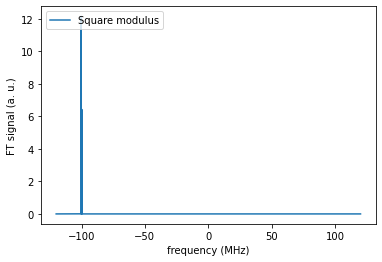

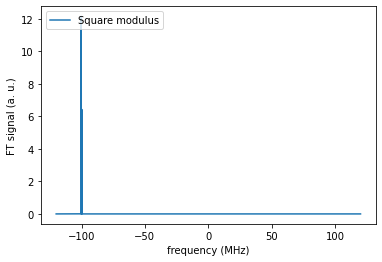

In [43]:
plot_fourier_transform(f, ft, square_modulus=True, show = False)

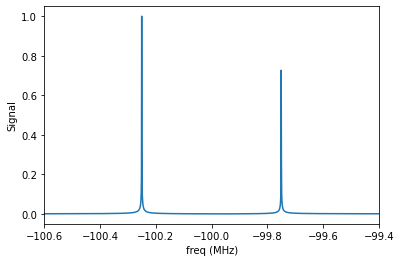

In [44]:
plt.plot(f, np.abs(ft)/np.max(np.abs(ft)))

plt.xlabel('freq (MHz)')
plt.ylabel('Signal')
plt.xlim([-100.6, -99.4])
# plt.legend()
plt.show()

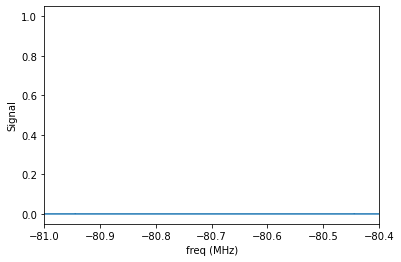

In [45]:
plt.plot(f, np.abs(ft)/np.max(np.abs(ft)))

plt.xlabel('freq (MHz)')
plt.ylabel('Signal')
plt.xlim([-81.0, -80.4])
# plt.legend()
plt.show()